# Aztec G-dDT Test Run

In [1]:
import sys
sys.path.append('../')

import pandas as pd
import os
import plotly.express as px
import seaborn as sns 
import matplotlib.pyplot as plt

import plotly.io as pio
pio.renderers.default = "png"

## Perform Simulation

In [7]:
from aztec_gddt.experiment import test_run
from aztec_gddt.scenario_experiments import scenario_group_1_experiment

exp = scenario_group_1_experiment(N_timesteps=500, N_samples=2, N_config_sample=30)


from cadCAD.engine import ExecutionContext, ExecutionMode, Executor


_exec_mode = ExecutionMode().single_mode
exec_context = ExecutionContext(_exec_mode, additional_objs={'deepcopy_off': True})
executor = Executor(exec_context=exec_context, configs=exp.configs, supress_print=False)

# Execute the cadCAD experiment
(records, tensor_field, _) = executor.execute()

# Parse the output as a pandas DataFrame
df = pd.DataFrame(records)

# Drop substeps
first_ind = (df.substep == 0) & (df.timestep == 0)
last_ind = df.substep == max(df.substep)
inds_to_drop = first_ind | last_ind
df = df.loc[inds_to_drop].drop(columns=['substep'])


# Assign Params
M_dict = exp.configs[0].sim_config['M']
params_set = set(M_dict.keys())

selected_params = params_set
# Attribute parameters to each row*

from cadCAD.tools.execution.easy_run import select_config_M_dict # type: ignore
params_dict = select_config_M_dict(exp.configs, 0, selected_params)

# Handles all cases of parameter types including list
for key, value in params_dict.items():
    df[key] = df.apply(lambda _: value, axis=1)

for i, (_, n_df) in enumerate(df.groupby(['simulation', 'subset', 'run'])):
    params_dict = select_config_M_dict(exp.configs, i, selected_params)
    for key, value in params_dict.items():
        df.loc[n_df.index, key] = df.loc[n_df.index].apply(
            lambda _: value, axis=1)
        

sim_df = df


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.5.3
Execution Mode: single_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (2, 1000, 78, 30, 32)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (500, 39, 18, 32)
     Simulation 1: (Timesteps, Params, Runs, Sub-States) = (500, 39, 12, 32)


Initializing configurations:   0%|          | 0/30 [00:00<?, ?it/s]

Execution Method: single_proc_exec


Flattening results:   0%|          | 0/105030 [00:00<?, ?it/s]

Total execution time: 8.34s


## Visualization over Model Features

In [8]:
sim_df.head(5)

,timestep,l1_blocks_passed,delta_l1_blocks,l2_blocks_passed,agents,validator_set,current_epoch,last_epoch,last_reward_time_in_l1,last_reward,...,BOND_SLASH_PERCENT,AVERAGE_TX_COUNT_PER_SLOT,PROVING_COST_MODIFICATION_E,FEE_JUICE_PRICE_MODIFICATION_E,ORACLE_UPDATE_FREQUENCY_E,JUICE_PER_WEI_MEAN,JUICE_PER_WEI_COV,MAX_FEE_INFLATION_RELATIVE_MEAN,MAX_FEE_INFLATION_RELATIVE_STD,market_price_eth
0,0,0,0,0,"[Agent(uuid='0', commitment_bond=1.87599208270...",{},"Epoch(init_time_in_l1=-999, validators=[], slo...","Epoch(init_time_in_l1=-999, validators=[], slo...",0,1500.0,...,1.0,360,0.005,0.001,0.5,1.000000e-14,0.3,1.0,0.1,3300
7,1,1,1,1,"[Agent(uuid='0', commitment_bond=1.87599208270...",{},"Epoch(init_time_in_l1=1, validators=['164', '1...","Epoch(init_time_in_l1=-999, validators=[], slo...",0,1500.0,...,1.0,360,0.005,0.001,0.5,1.000000e-14,0.3,1.0,0.1,3300
14,2,2,1,1,"[Agent(uuid='0', commitment_bond=1.87599208270...",{},"Epoch(init_time_in_l1=1, validators=['164', '1...","Epoch(init_time_in_l1=-999, validators=[], slo...",0,1500.0,...,1.0,360,0.005,0.001,0.5,1.000000e-14,0.3,1.0,0.1,3300
21,3,3,1,1,"[Agent(uuid='0', commitment_bond=1.87599208270...",{},"Epoch(init_time_in_l1=1, validators=['164', '1...","Epoch(init_time_in_l1=-999, validators=[], slo...",0,1500.0,...,1.0,360,0.005,0.001,0.5,1.000000e-14,0.3,1.0,0.1,3300
28,4,4,1,2,"[Agent(uuid='0', commitment_bond=1.87599208270...",{},"Epoch(init_time_in_l1=1, validators=['164', '1...","Epoch(init_time_in_l1=-999, validators=[], slo...",0,1500.0,...,1.0,360,0.005,0.001,0.5,1.000000e-14,0.3,1.0,0.1,3300


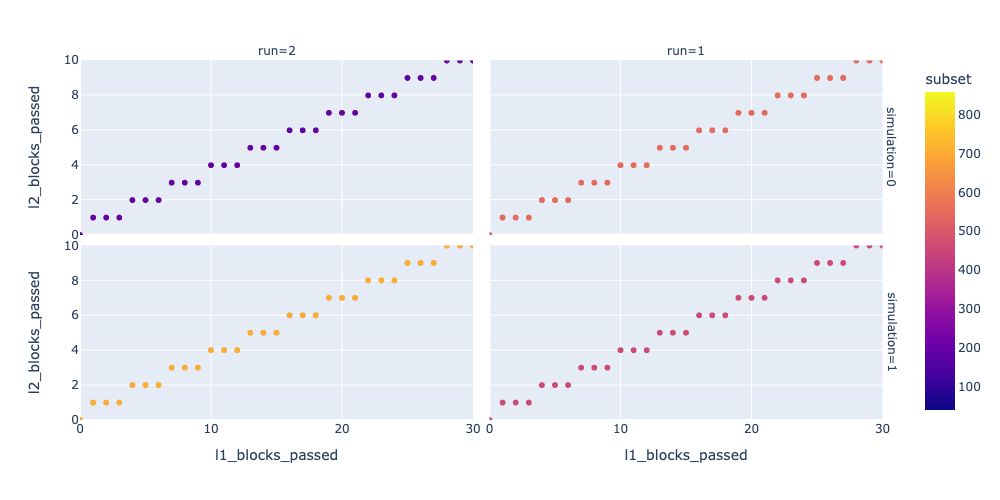

In [9]:
fig = px.scatter(sim_df.reset_index(), x='l1_blocks_passed', y='l2_blocks_passed', color='subset', facet_col='run', facet_row='simulation')
fig.update_layout(yaxis_range=[0, 10], xaxis_range=[0,  10 * 3], width=1000, height=500)
fig.show()

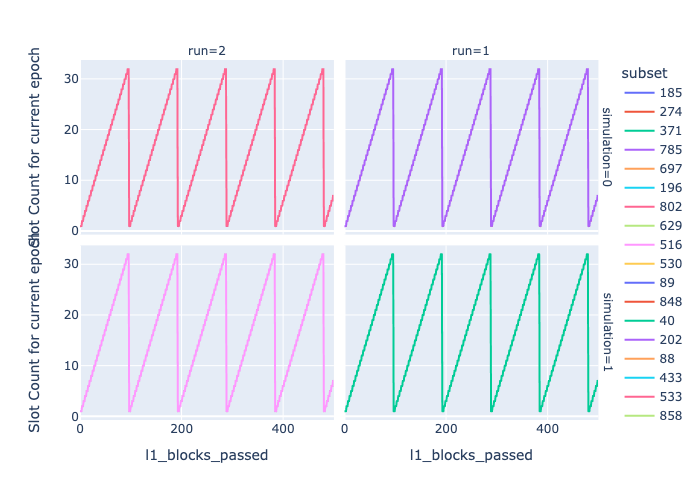

In [10]:
y = sim_df.current_epoch.map(lambda x: len(x.slots))

fig = px.line(sim_df, x='l1_blocks_passed', y=y, labels={"x": 'timestep', 'y': 'Slot Count for current epoch'}, color='subset', facet_col='run', facet_row='simulation')
fig.show()

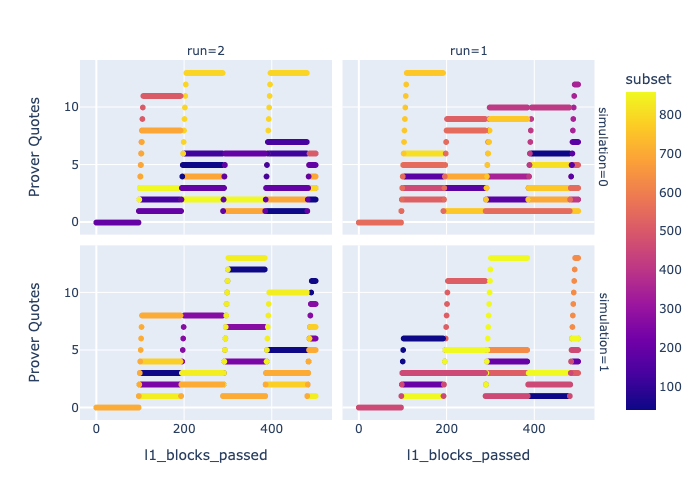

In [11]:
y = sim_df.last_epoch.map(lambda x: len(x.prover_quotes))

fig = px.scatter(sim_df, x='l1_blocks_passed', y=y, labels={"x": 'timestep', 'y': 'Prover Quotes'}, color='subset', facet_col='run', facet_row='simulation')
fig.show()

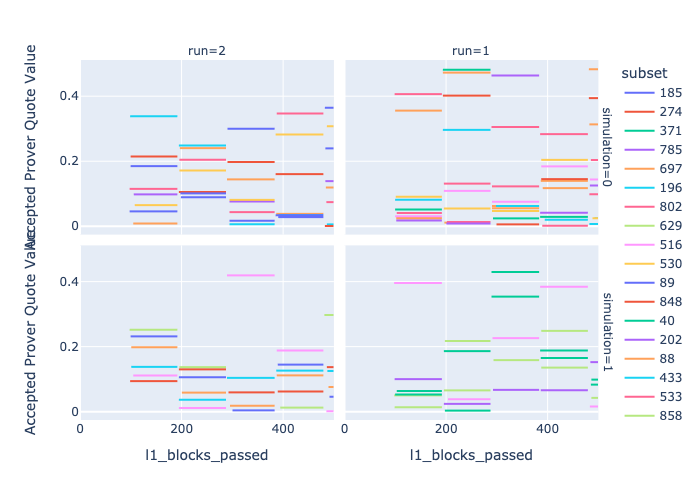

In [12]:
y = sim_df.last_epoch.map(lambda x: x.accepted_prover_quote)

fig = px.line(sim_df, x='l1_blocks_passed', y=y, labels={"x": 'timestep', 'y': 'Accepted Prover Quote Value'}, color='subset', facet_col='run', facet_row='simulation')
fig.show()

## Visualization over PSUU Per-Trajectory Metrics

In [13]:
from aztec_gddt.psuu.metrics import *


RELEVANT_PER_TRAJECTORY_METRICS = ['T-M1', 'T-M2', 'T-M3']
RELEVANT_PER_TRAJECTORY_GROUP_METRICS = ['TG-M1', 'TG-M2', 'TG-M3']

In [14]:
for label in RELEVANT_PER_TRAJECTORY_METRICS:
    fn = PER_TRAJECTORY_METRICS[label]
    print(f"{label}: {fn.__name__}")
    print(sim_df.reset_index().groupby(['simulation', 'subset', 'run']).apply(fn, include_groups=False))
    print("---")

T-M1: relative_volatility_across_time
simulation  subset  run
0           88      1      7.789236e-15
            112     2      1.893694e-15
            185     2      2.215626e-14
            196     2      4.662337e-16
            210     1      1.519726e-15
            251     2      1.472124e-14
            371     1      7.759727e-14
            433     1      1.243796e-13
            477     1      9.990076e-16
            530     2      6.752158e-15
            533     1      7.721712e-15
            561     1      1.931169e-14
            697     1      7.916295e-15
                    2      1.803356e-14
            759     1      4.637027e-15
            785     2      1.527836e-14
            802     1      1.767663e-14
            848     2      1.268552e-15
1           40      1      1.423098e-15
            89      2      6.475478e-14
            202     1      1.534883e-15
            274     2      2.616628e-15
            298     2      2.517512e-15
            457   

In [15]:
for label in RELEVANT_PER_TRAJECTORY_GROUP_METRICS:
    fn = PER_TRAJECTORY_GROUP_METRICS[label]

    groups = list(sim_df.reset_index().groupby(['simulation']))
    for i, g in groups:
        dfs = [el[1] for el in list(g.groupby('run'))]
        print(f"{label}: {fn.__name__}")
        print(fn(dfs))
        print("---")    

TG-M1: <lambda>
4.894416131351825e-15
---
TG-M1: <lambda>
8.170380243845851e-16
---
TG-M2: <lambda>
2.0
---
TG-M2: <lambda>
1.5
---
TG-M3: <lambda>
1.0
---
TG-M3: <lambda>
1.0
---


In [16]:
control_params = [
        'RELATIVE_TARGET_MANA_PER_BLOCK',
        'MAXIMUM_MANA_PER_BLOCK',
        'MINIMUM_MULTIPLIER_CONGESTION',
        'RELATIVE_UPDATE_FRACTION_CONGESTION',
        'OVERHEAD_MANA_PER_TX',
        'MAXIMUM_UPDATE_PERCENTAGE_C',
        ]

In [17]:
group_params = ['simulation', 'subset'] + control_params


records = []

for label in RELEVANT_PER_TRAJECTORY_GROUP_METRICS:
    fn = PER_TRAJECTORY_GROUP_METRICS[label]

    groups = list(sim_df.reset_index().groupby(group_params))
    for i, g in groups:
        dfs = [el[1] for el in list(g.groupby('run'))]
        value = fn(dfs)
        record = dict(zip(group_params, i))
        record['metric'] = label
        record['metric_value'] = value
        records.append(record)


In [18]:
agg_df = pd.DataFrame(records).groupby(group_params + ['metric']).metric_value.first().unstack().reset_index()
agg_df['TG-aM1'] = agg_df['TG-M1'] < agg_df['TG-M1'].median()

In [19]:
from aztec_gddt.psuu.metrics import *


# for control_param in control_params:
#     print(f"### {control_param} ###")
#     groups = list(sim_df.reset_index().groupby([control_param]))

#     for i, g in groups:
#         print(f"{control_param} = {i}")
#         for label, fn in PER_TRAJECTORY_GROUP_METRICS.items():
#             dfs = [el[1] for el in list(g.groupby(['simulation', 'subset', 'run']))]
#             print(f"{label}={fn(dfs) :.3f}")
#         print("---")

In [20]:
text = f"""
#### Computational Complexity:
1. Total number of parameter combinations: {len(sim_df.subset.unique()):,}
2. Total number of Monte Carlo runs per parameter combination: {len(sim_df.run.unique()):,}
3. Total number of trajectories: {len(sim_df[['subset', 'run']].drop_duplicates()):,}
4. Total number of timesteps per trajectory: {sim_df.timestep.max():,}
5. Total number of state measurements: {len(sim_df):,}
"""

print(text)


#### Computational Complexity:
1. Total number of parameter combinations: 29
2. Total number of Monte Carlo runs per parameter combination: 2
3. Total number of trajectories: 30
4. Total number of timesteps per trajectory: 500
5. Total number of state measurements: 15,030



### Adaptive Grid Results

### Protocol Parameter Recommendations 


| Control Parameter | Recommended Range | Unit |
| - | - | - |
| RELATIVE_TARGET_MANA_PER_BLOCK | tbd | Mana |
| MAXIMUM_MANA_PER_BLOCK | tbd | Mana |
| MINIMUM_MULTIPLIER_CONGESTION | tbd | Unitless |
| UPDATE_FRACTION_CONGESTION | tbd | 1 / Mana |
| OVERHEAD_MANA_PER_TX | tbd | Mana |
| PROVING_COST_MODIFIER_INITIAL_C | tbd | Mana |
| FEE_JUICE_PRICE_MODIFIER_INITIAL_C | tbd | Juice per Wei |
| MAXIMUM_UPDATE_PERCENTAGE_C | tbd | Unitless |

### Decision Tree and Parameter Importance

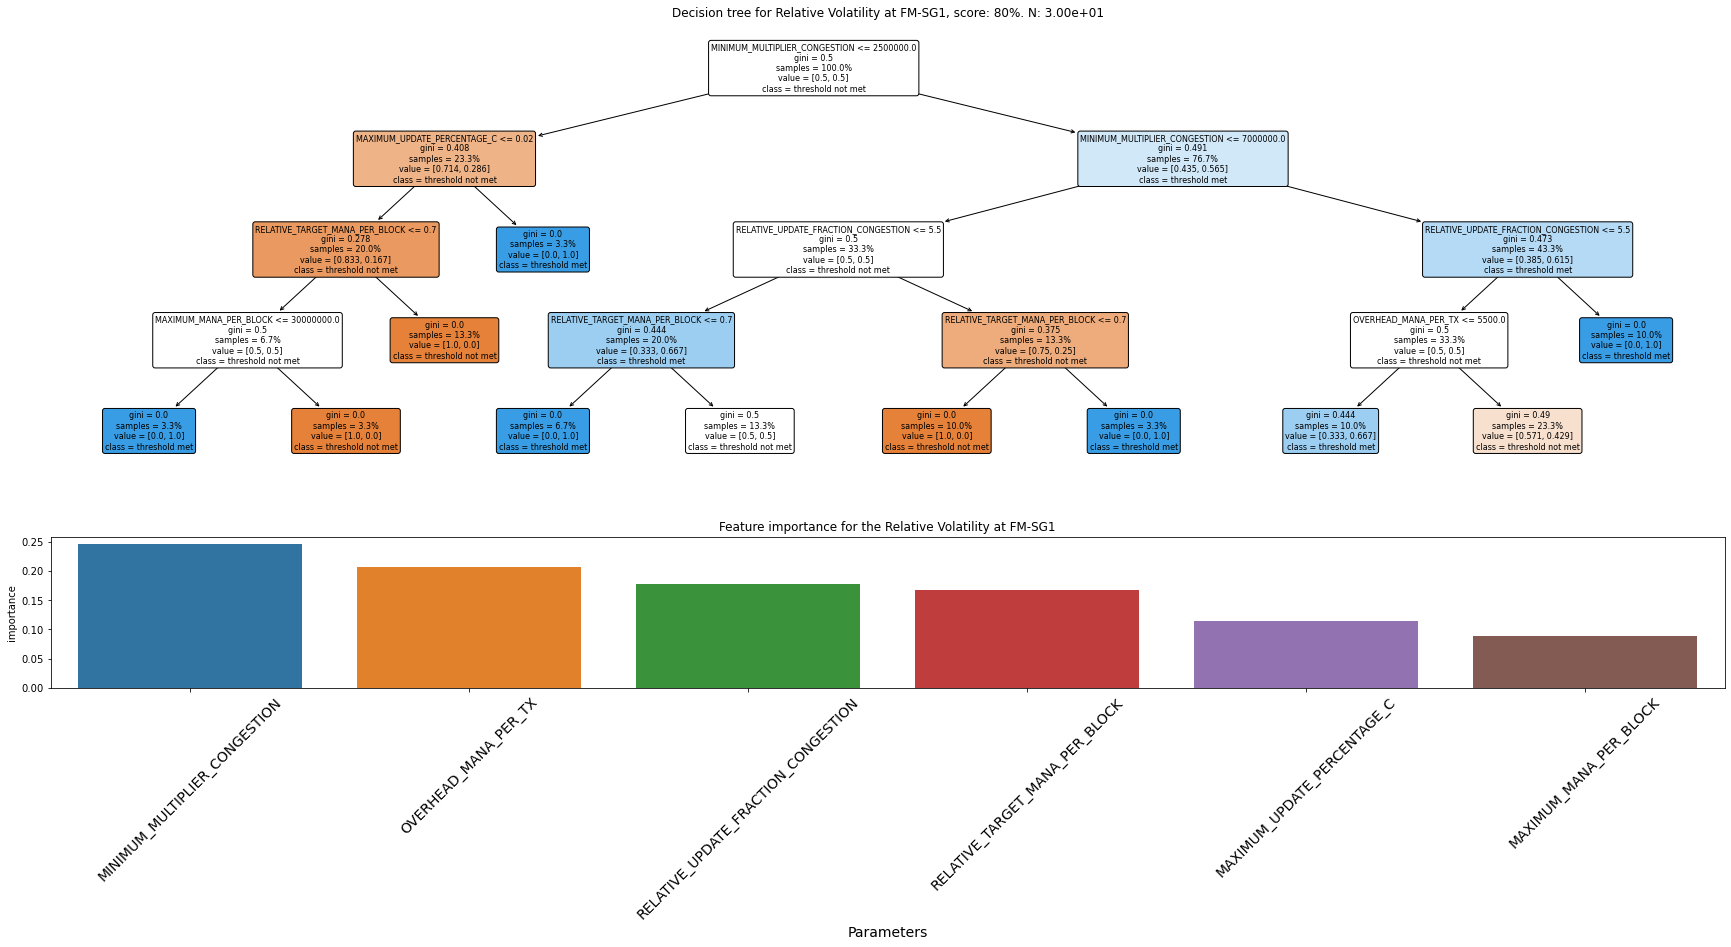

In [21]:
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

def fit_predict(X: pd.DataFrame,
      y: pd.Series,
      target: str,
      ax_dt: object,
      ax_rf: object,
      label: str = 'target',
      font_size: int = 12):
    """
    Fit DT and RF classifiers for summarizing the sensivity.
    """
    model = DecisionTreeClassifier(class_weight='balanced',
                                   max_depth=4,
                                   )
    rf = RandomForestClassifier()
    model.fit(X, y)
    rf.fit(X, y)


    df = (pd.DataFrame(list(zip(X.columns, rf.feature_importances_)),
                        columns=['features', 'importance'])
            .sort_values(by='importance', ascending=False)
            )

    plot_tree(model,
                rounded=True,
                proportion=True,
                fontsize=font_size,
                feature_names=list(X.columns),
                class_names=['threshold not met', 'threshold met'],
                filled=True,
                ax=ax_dt)
    ax_dt.set_title(
        f'Decision tree for {label}, score: {model.score(X, y) :.0%}. N: {len(X) :.2e}')
    sns.barplot(data=df,
                x=df.features,
                y=df.importance,
                ax=ax_rf,
                label='small')
    plt.setp(ax_rf.xaxis.get_majorticklabels(), rotation=45)
    ax_rf.tick_params(axis='x', labelsize=14)
    ax_rf.set_xlabel("Parameters", fontsize=14)
    ax_rf.set_title(f'Feature importance for the {label}')
    
    return df.assign(target=target)



def param_sensitivity_plot(df: pd.DataFrame,
                           control_params: set,
                           target: str,
                           label: str = 'target',
                           height: int = 12,
                           width: int = 30,
                           font_size: int = 8):
    """
    Plot the sensivity of the 'target' column vs
    a list of control parameters, which are data frame columns.
    """
    
    features = set(control_params) - {target}
    X = df.loc[:, list(features)]
    y = (df[target] > 0)
    # Visualize
    fig, axes = plt.subplots(nrows=2,
                             figsize=(width, height),
                             dpi=72,
                             gridspec_kw={'height_ratios': [3, 1]})
    fit_predict(X, y, 'target', axes[0], axes[1], label, font_size)

    return None


param_sensitivity_plot(agg_df, control_params, 'TG-aM1', label='Relative Volatility at FM-SG1')

In [22]:
sim_df.columns[:37]

Index(['timestep', 'l1_blocks_passed', 'delta_l1_blocks', 'l2_blocks_passed',
       'agents', 'validator_set', 'current_epoch', 'last_epoch',
       'last_reward_time_in_l1', 'last_reward', 'market_price_juice_per_wei',
       'market_price_l1_gas', 'market_price_l1_blobgas',
       'oracle_price_juice_per_wei', 'oracle_price_l1_gas',
       'oracle_price_l1_blobgas', 'update_time_oracle_price_juice_per_wei',
       'update_time_oracle_price_l1_gas',
       'update_time_oracle_price_l1_blobgas', 'oracle_proving_cost',
       'congestion_multiplier', 'excess_mana', 'base_fee', 'cumm_empty_blocks',
       'cumm_unproven_epochs', 'cumm_dropped_tx', 'cumm_excl_tx',
       'cumm_total_tx', 'cumm_resolved_epochs', 'cumm_finalized_epochs',
       'cumm_mana_used_on_finalized_blocks', 'cumm_finalized_blocks',
       'simulation', 'subset', 'run', 'label', 'timestep_in_l1_blocks'],
      dtype='object')

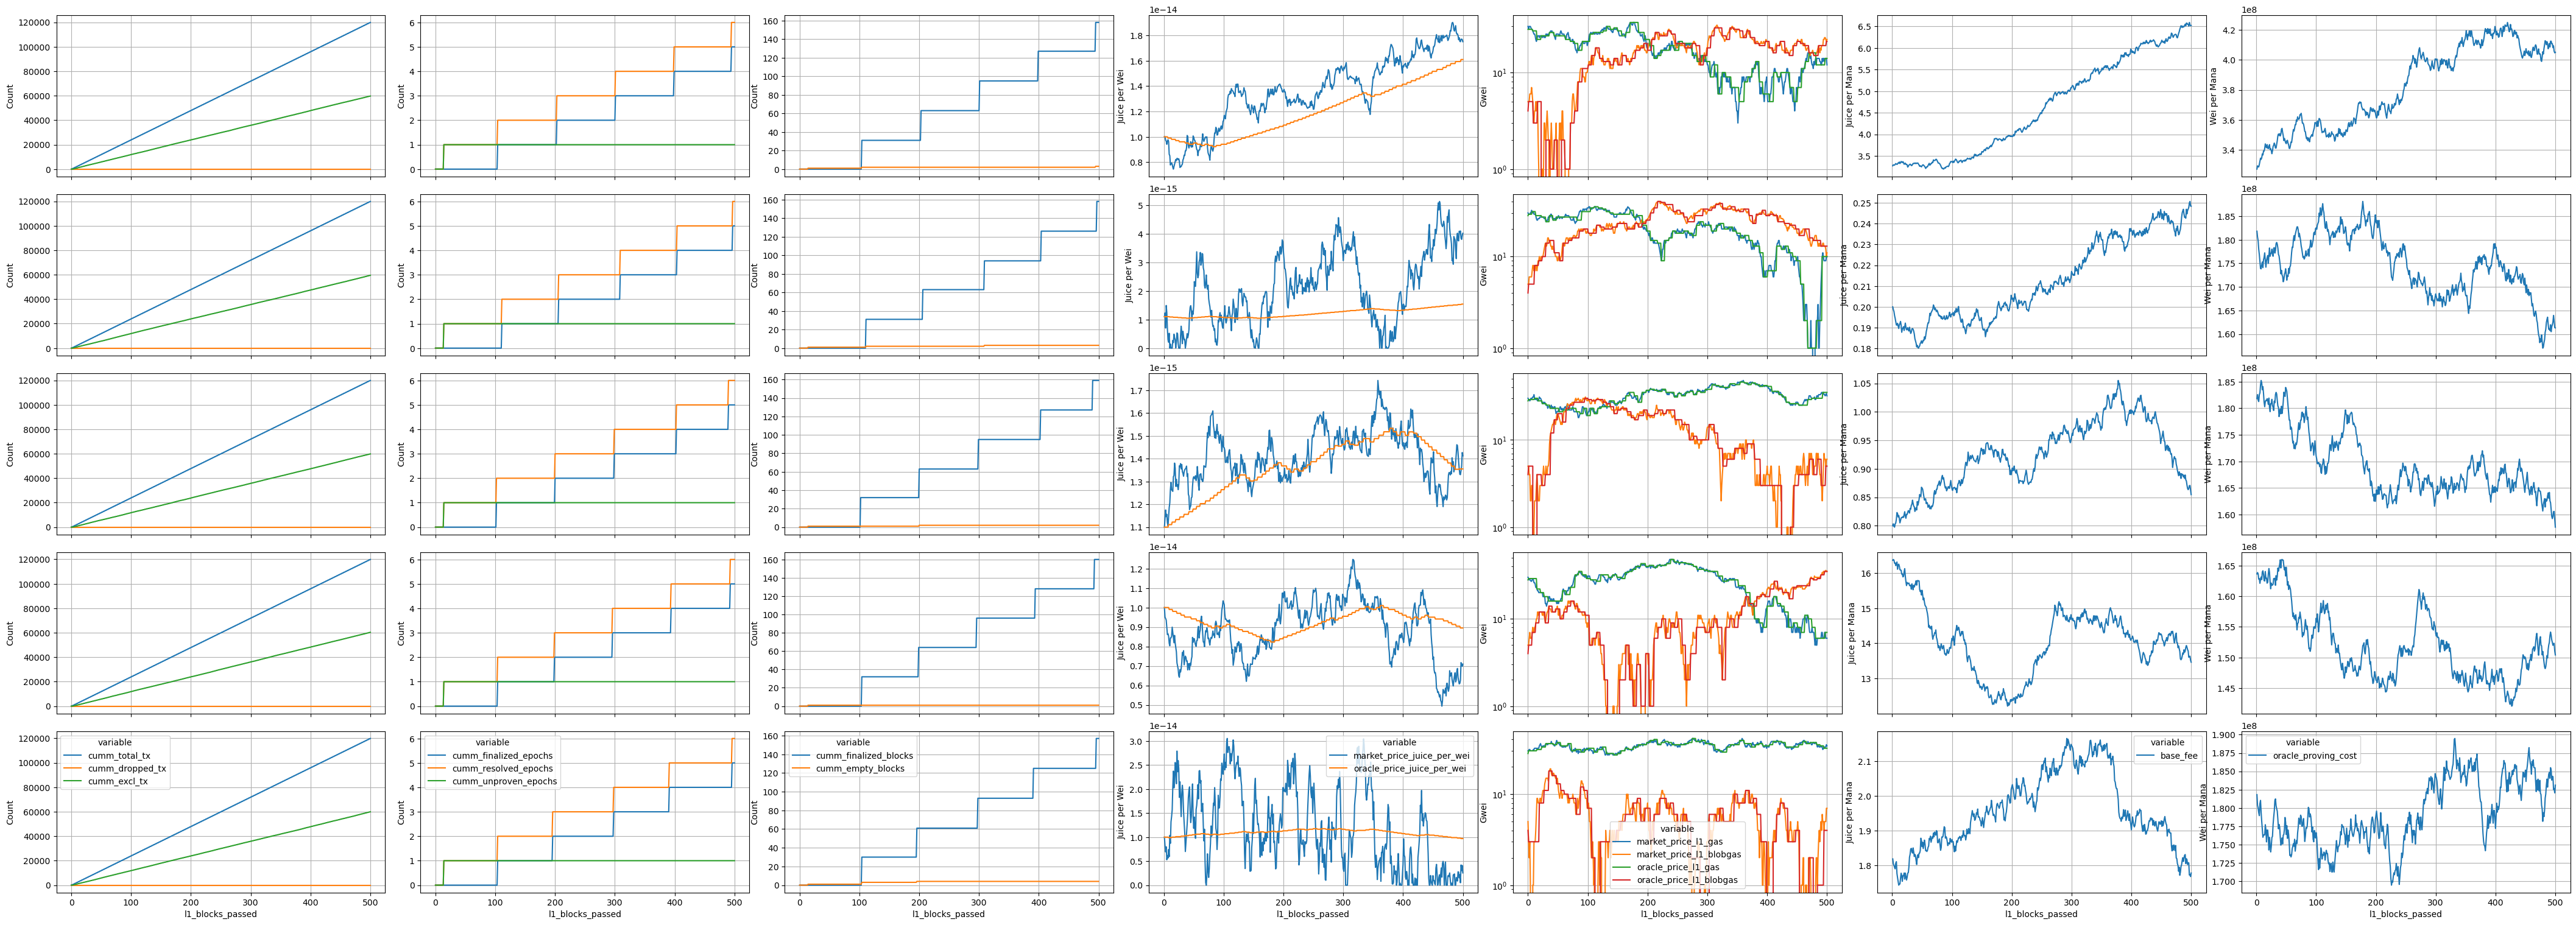

In [23]:
from random import choices
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

cols_1 = ['cumm_total_tx', 'cumm_dropped_tx', 'cumm_excl_tx'] # Count

cols_2 = ['cumm_finalized_epochs', 'cumm_resolved_epochs', 'cumm_unproven_epochs'] # Count

cols_3 = ['cumm_finalized_blocks', 'cumm_empty_blocks'] # Count

cols_4 = ['market_price_juice_per_wei', 'oracle_price_juice_per_wei', ] # Juice per Wei

cols_5 = ['market_price_l1_gas', 'market_price_l1_blobgas', 'oracle_price_l1_gas', 'oracle_price_l1_blobgas'] # Wei per Gas

cols_6 = ['base_fee'] # Juice per Mana

cols_7 = ['oracle_proving_cost'] # Wei per Mana


N_subsets = 5
N_cols = 7
size_per_col = 6
size_per_row = 3

groupings = list(sim_df.groupby(['simulation', 'subset', 'run',]))
trajectory_dfs = choices([el[1] for el in groupings], k=N_subsets)

X_COL = 'l1_blocks_passed'
    
fig, axes = plt.subplots(nrows=N_subsets, ncols=N_cols, figsize=(N_cols*size_per_col, N_subsets*size_per_row), sharex=True)
fig.tight_layout()
for i in range(N_subsets):
    traj_df = (trajectory_dfs[i])



    melted_df = traj_df.reset_index().melt(id_vars=[X_COL], value_vars=cols_1)
    ax=axes[i][0]
    sns.lineplot(melted_df, x=X_COL, y='value', hue='variable', ax=ax)
    ax.grid()
    ax.set_yscale('linear')
    ax.set_ylabel('Count')
    if i < N_subsets - 1:
     ax.get_legend().remove()
    
    ax = axes[i][1]
    melted_df = traj_df.reset_index().melt(id_vars=[X_COL], value_vars=cols_2)
    sns.lineplot(melted_df, x=X_COL, y='value', hue='variable', ax=ax)
    ax.grid()
    ax.set_yscale('linear')
    ax.set_ylabel('Count')
    if i < N_subsets - 1:
     ax.get_legend().remove()


    melted_df = traj_df.reset_index().melt(id_vars=[X_COL], value_vars=cols_3)
    melted_df['value']
    ax=axes[i][2]
    sns.lineplot(melted_df, x=X_COL, y='value', hue='variable', ax=ax)
    ax.grid()
    ax.set_ylabel('Count')
    if i < N_subsets - 1:
     ax.get_legend().remove()
    
    ax = axes[i][3]
    melted_df = traj_df.reset_index().melt(id_vars=[X_COL], value_vars=cols_4)
    sns.lineplot(melted_df, x=X_COL, y='value', hue='variable', ax=ax)
    ax.grid()
    ax.set_yscale('linear')
    ax.set_ylabel('Juice per Wei')
    if i < N_subsets - 1:
     ax.get_legend().remove()


    ax = axes[i][4]
    melted_df = traj_df.reset_index().melt(id_vars=[X_COL], value_vars=cols_5)
    sns.lineplot(melted_df, x=X_COL, y='value', hue='variable', ax=ax)
    ax.grid()
    ax.set_yscale('log')
    ax.set_ylabel('Gwei')
    if i < N_subsets - 1:
     ax.get_legend().remove()

    ax = axes[i][5]
    melted_df = traj_df.reset_index().melt(id_vars=[X_COL], value_vars=cols_6)
    sns.lineplot(melted_df, x=X_COL, y='value', hue='variable', ax=ax)
    ax.grid()
    # ax.set_yscale('log')
    ax.set_ylabel('Juice per Mana')
    if i < N_subsets - 1:
     ax.get_legend().remove()

    ax = axes[i][6]
    melted_df = traj_df.reset_index().melt(id_vars=[X_COL], value_vars=cols_7)
    sns.lineplot(melted_df, x=X_COL, y='value', hue='variable', ax=ax)
    ax.grid()
    # ax.set_yscale('log')
    ax.set_ylabel('Wei per Mana')
    if i < N_subsets - 1:
     ax.get_legend().remove()


plt.show()

### Commentary on Results:
